In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, sum as spark_sum, desc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np

In [3]:
spark = SparkSession.builder \
    .appName('Disease Diagnosis EDA') \
    .config('spark.driver.memory', '4g') \
    .config('spark.executor.memory', '4g') \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/16 22:06:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
data_path = '../data/Final_Augmented_dataset_Diseases_and_Symptoms.csv'

df = spark.read.csv(data_path, header=True, inferSchema=True)
df.head(5)

25/04/16 22:06:19 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[Row(diseases='panic disorder', anxiety and nervousness=1, depression=0, shortness of breath=1, depressive or psychotic symptoms=1, sharp chest pain=0, dizziness=0, insomnia=0, abnormal involuntary movements=0, chest tightness=1, palpitations=1, irregular heartbeat=1, breathing fast=1, hoarse voice=0, sore throat=0, difficulty speaking=0, cough=0, nasal congestion=0, throat swelling=0, diminished hearing=0, lump in throat=0, throat feels tight=0, difficulty in swallowing=0, skin swelling=0, retention of urine=0, groin mass=0, leg pain=0, hip pain=0, suprapubic pain=0, blood in stool=0, lack of growth=0, emotional symptoms=0, elbow weakness=0, back weakness=0, pus in sputum=0, symptoms of the scrotum and testes=0, swelling of scrotum=0, pain in testicles=0, flatulence=0, pus draining from ear=0, jaundice=0, mass in scrotum=0, white discharge from eye=0, irritable infant=0, abusing alcohol=0, fainting=0, hostile behavior=0, drug abuse=0, sharp abdominal pain=0, feeling ill=0, vomiting=0,

In [5]:
print(f"Total No of records: {df.count()}")
print(f"Total No of columns: {len(df.columns)}")

Total No of records: 246945
Total No of columns: 378


In [6]:
print('\nSchema:')

df.printSchema()


Schema:
root
 |-- diseases: string (nullable = true)
 |-- anxiety and nervousness: integer (nullable = true)
 |-- depression: integer (nullable = true)
 |-- shortness of breath: integer (nullable = true)
 |-- depressive or psychotic symptoms: integer (nullable = true)
 |-- sharp chest pain: integer (nullable = true)
 |-- dizziness: integer (nullable = true)
 |-- insomnia: integer (nullable = true)
 |-- abnormal involuntary movements: integer (nullable = true)
 |-- chest tightness: integer (nullable = true)
 |-- palpitations: integer (nullable = true)
 |-- irregular heartbeat: integer (nullable = true)
 |-- breathing fast: integer (nullable = true)
 |-- hoarse voice: integer (nullable = true)
 |-- sore throat: integer (nullable = true)
 |-- difficulty speaking: integer (nullable = true)
 |-- cough: integer (nullable = true)
 |-- nasal congestion: integer (nullable = true)
 |-- throat swelling: integer (nullable = true)
 |-- diminished hearing: integer (nullable = true)
 |-- lump in thr

In [7]:
# Display a sample of data
print("\nSample Data:")
df.show(5, truncate=False)


Sample Data:
+--------------+-----------------------+----------+-------------------+--------------------------------+----------------+---------+--------+------------------------------+---------------+------------+-------------------+--------------+------------+-----------+-------------------+-----+----------------+---------------+------------------+--------------+------------------+------------------------+-------------+------------------+----------+--------+--------+---------------+--------------+--------------+------------------+--------------+-------------+-------------+----------------------------------+-------------------+-----------------+----------+---------------------+--------+---------------+------------------------+----------------+---------------+--------+----------------+----------+--------------------+-----------+--------+--------+------+--------+---------------+---------------+-----------------+---------------------+-----------------------+------------------+-----------

In [8]:
# Basic statistics for diseases
disease_counts = df.groupBy("diseases").count().orderBy(desc("count"))
print("\nDisease Distribution (Top 20):")
disease_counts.show(20)


Disease Distribution (Top 20):


+--------------------+-----+
|            diseases|count|
+--------------------+-----+
|            cystitis| 1219|
|          vulvodynia| 1218|
|       nose disorder| 1218|
|complex regional ...| 1217|
|         spondylosis| 1216|
|        hypoglycemia| 1215|
|conjunctivitis du...| 1215|
|        vaginal cyst| 1215|
|peripheral nerve ...| 1215|
|         esophagitis| 1215|
|gastrointestinal ...| 1214|
|      diverticulitis| 1214|
|    acute bronchitis| 1213|
|infectious gastro...| 1212|
|fungal infection ...| 1212|
|           pneumonia| 1212|
|    sprain or strain| 1212|
|spontaneous abortion| 1212|
|                gout| 1211|
|     marijuana abuse| 1210|
+--------------------+-----+
only showing top 20 rows



In [9]:
pd_disease_counts = disease_counts.toPandas()

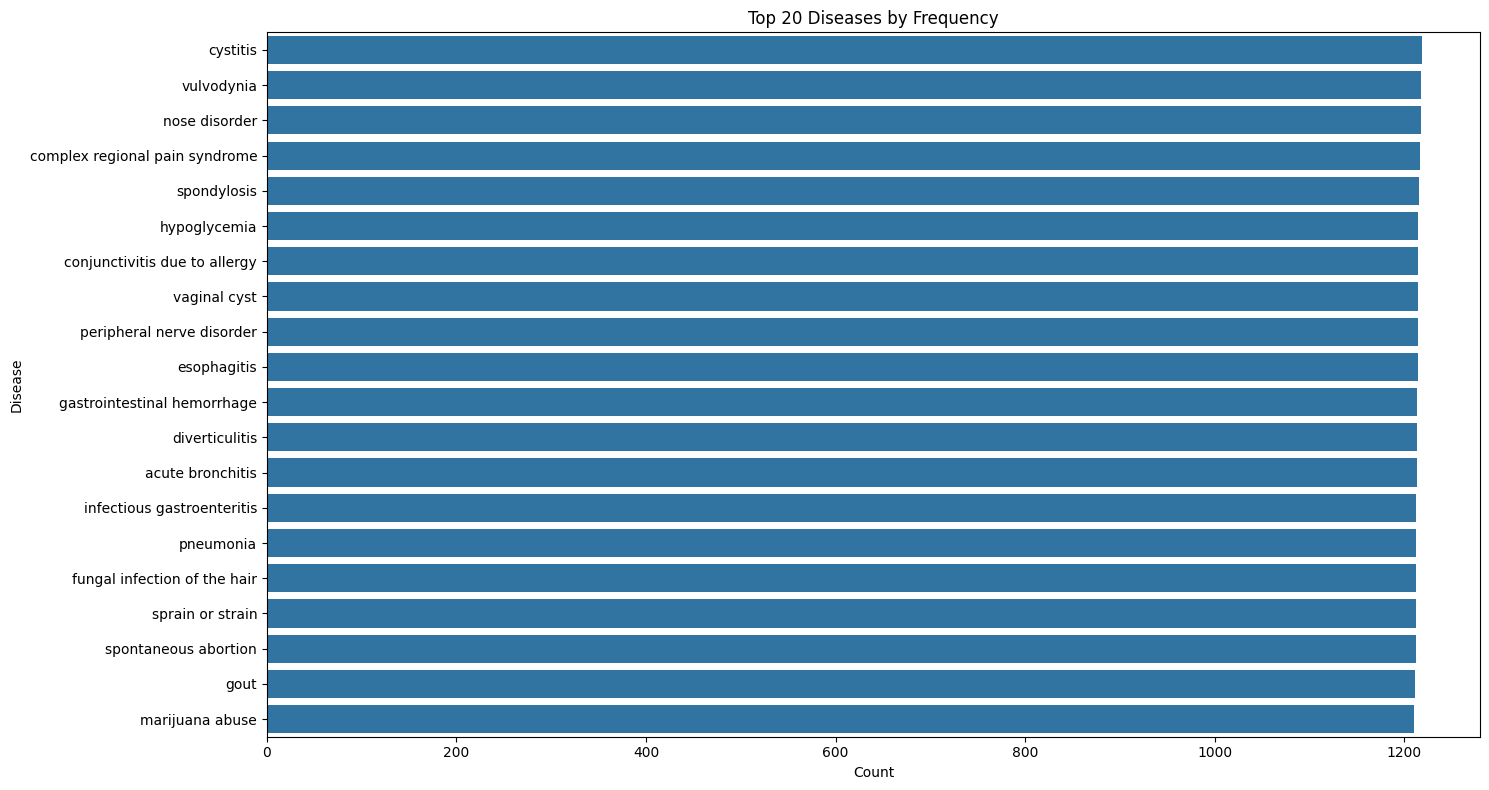

In [10]:
plt.figure(figsize=(15, 8))
sns.barplot(x="count", y="diseases", data=pd_disease_counts.head(20))
plt.title("Top 20 Diseases by Frequency")
plt.xlabel("Count")
plt.ylabel("Disease")
plt.tight_layout()
# plt.savefig("disease_distribution.png")
plt.show()

## Symptom prevalence analysis

In [12]:
# Convert to pandas DataFrame for visualization
symptom_df = pd.DataFrame(symptom_counts, columns=["Symptom", "Count"])
symptom_df = symptom_df.sort_values("Count", ascending=False)

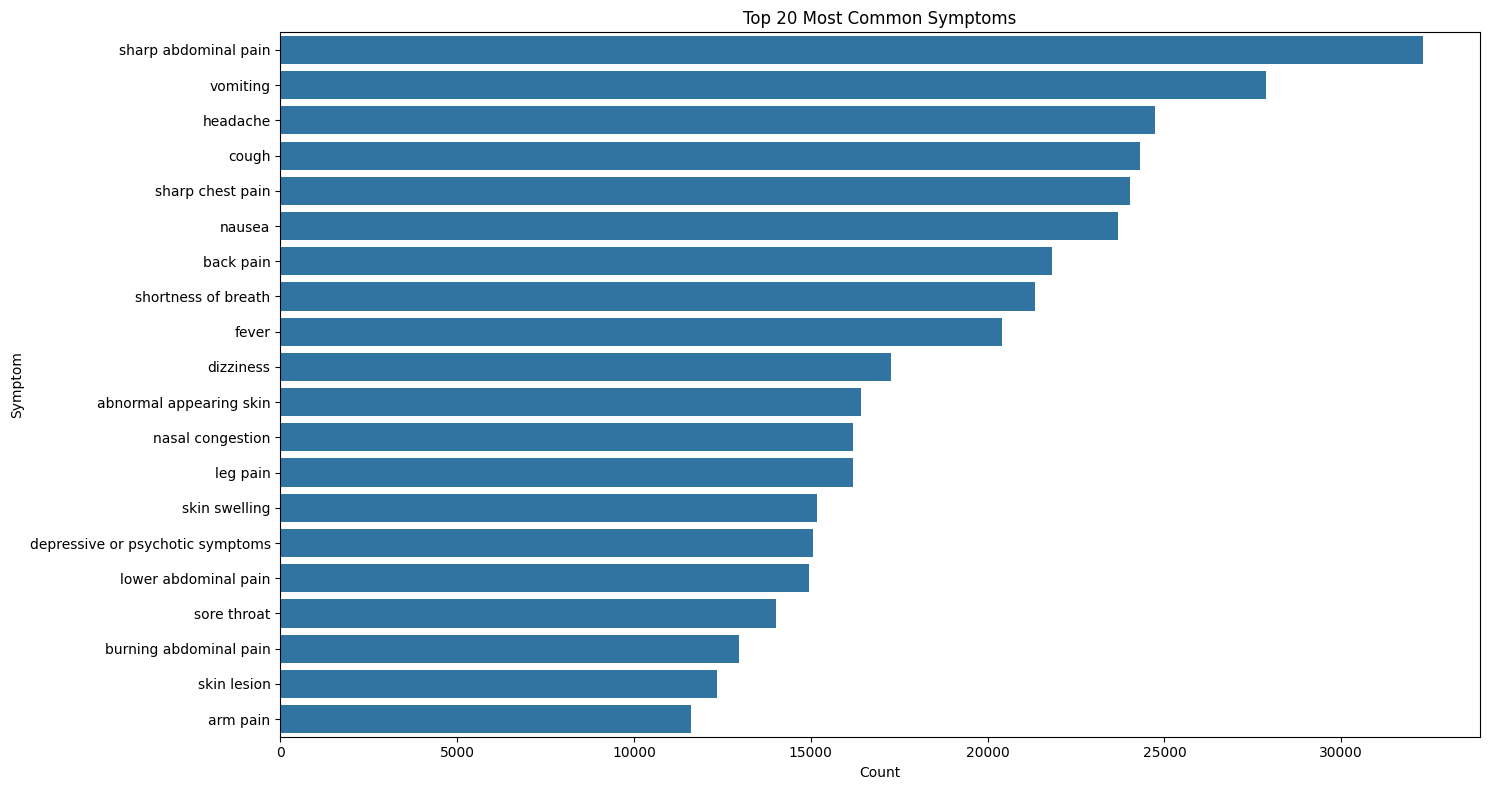

In [13]:
# Plot top symptoms
plt.figure(figsize=(15, 8))
sns.barplot(x="Count", y="Symptom", data=symptom_df.head(20))
plt.title("Top 20 Most Common Symptoms")
plt.xlabel("Count")
plt.ylabel("Symptom")
plt.tight_layout()
# plt.savefig("symptom_distribution.png")
plt.show()


In [14]:
# Correlation between symptoms (top 30 most common symptoms)
top_symptoms = symptom_df.head(30)["Symptom"].tolist()
correlation_df = df.select(["diseases"] + top_symptoms).toPandas()
correlation_matrix = correlation_df[top_symptoms].corr()

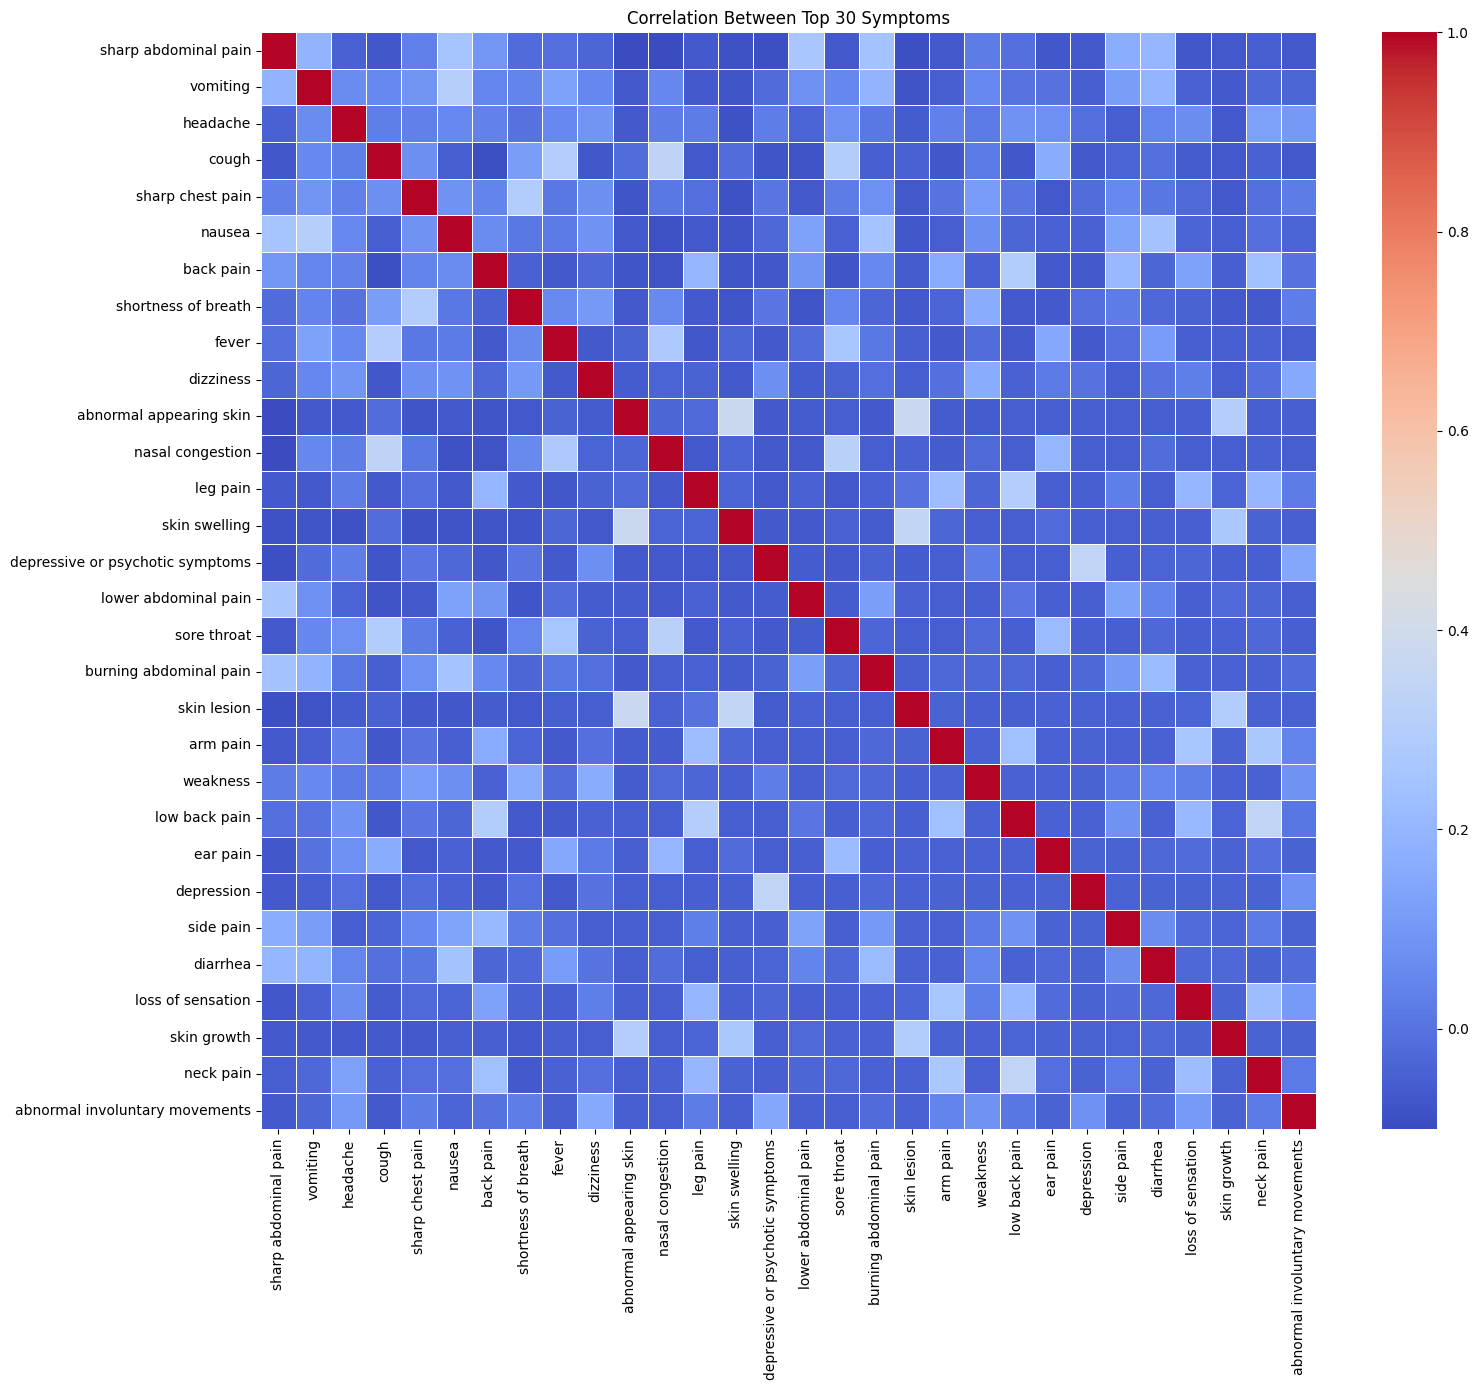

In [ ]:
# Plot correlation heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Between Top 30 Symptoms")
plt.tight_layout()
# plt.savefig("symptom_correlation.png")
plt.show()

# Symptoms per disease analysis

In [16]:
# Calculate average number of symptoms per disease
df_pd = df.toPandas()
df_pd["symptom_count"] = df_pd.iloc[:, 1:].sum(axis=1)

disease_symptom_counts = df_pd.groupby("diseases")["symptom_count"].mean().reset_index()
disease_symptom_counts = disease_symptom_counts.sort_values("symptom_count", ascending=False)

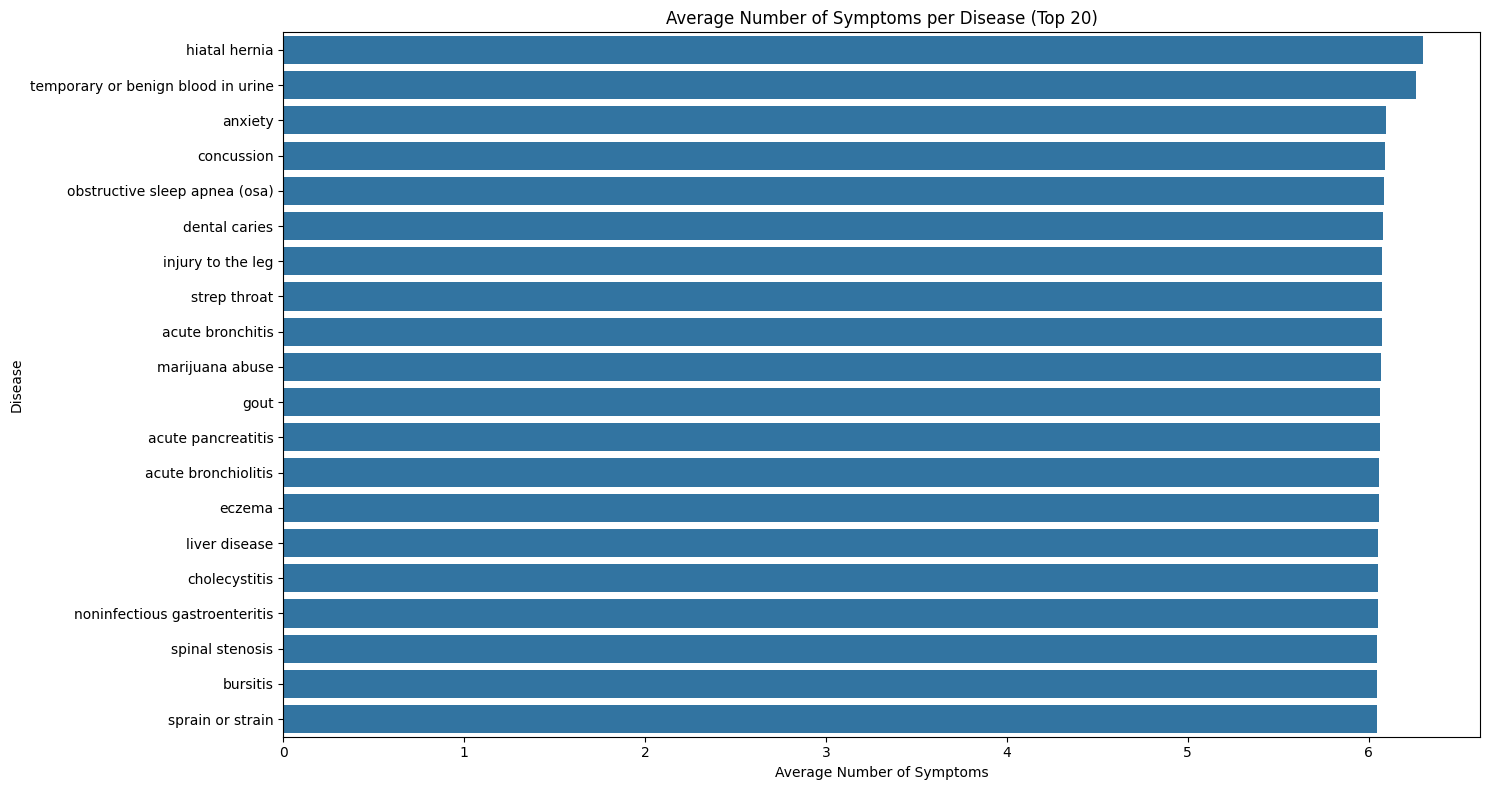

In [17]:
# Plot average symptoms per disease
plt.figure(figsize=(15, 8))
sns.barplot(x="symptom_count", y="diseases", data=disease_symptom_counts.head(20))
plt.title("Average Number of Symptoms per Disease (Top 20)")
plt.xlabel("Average Number of Symptoms")
plt.ylabel("Disease")
plt.tight_layout()
# plt.savefig("avg_symptoms_per_disease.png")
plt.show()

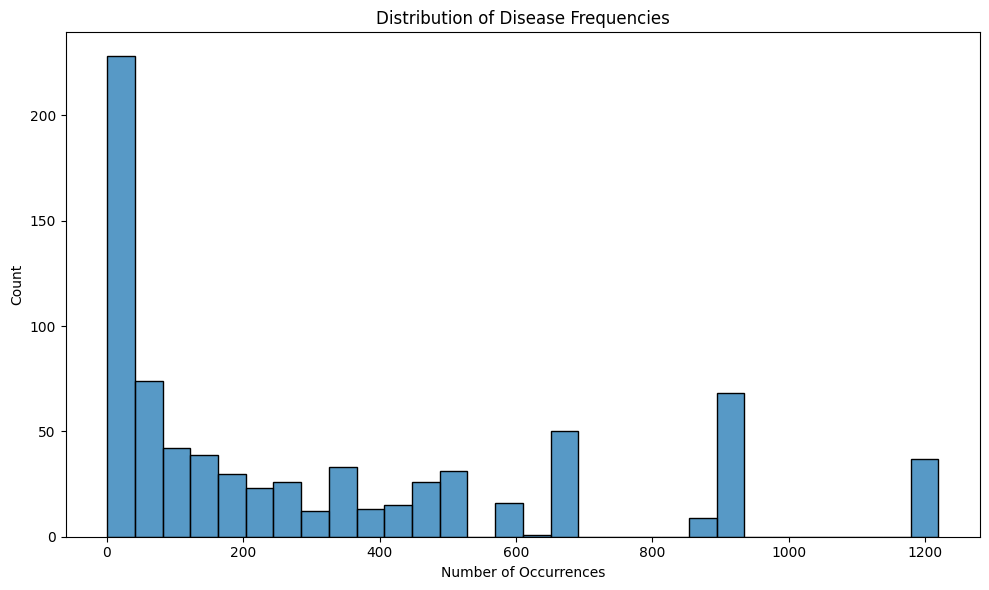

In [18]:
# Class imbalance check
plt.figure(figsize=(10, 6))
sns.histplot(pd_disease_counts["count"], bins=30)
plt.title("Distribution of Disease Frequencies")
plt.xlabel("Number of Occurrences")
plt.ylabel("Count")
plt.tight_layout()
# plt.savefig("disease_frequency_distribution.png")
plt.show()

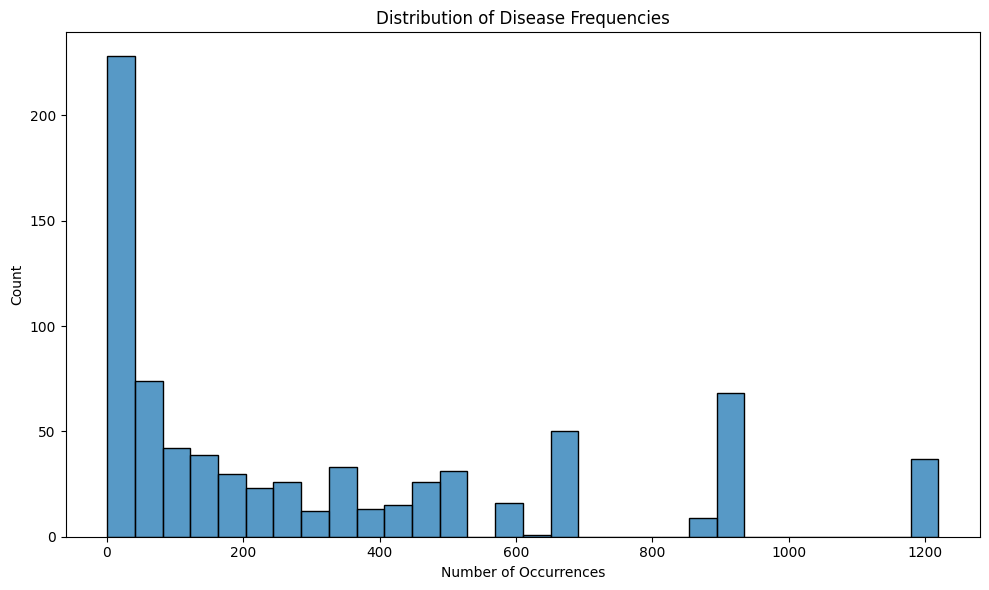

In [19]:
# Class imbalance check
plt.figure(figsize=(10, 6))
sns.histplot(pd_disease_counts["count"], bins=30)
plt.title("Distribution of Disease Frequencies")
plt.xlabel("Number of Occurrences")
plt.ylabel("Count")
plt.tight_layout()
# plt.savefig("disease_frequency_distribution.png")
plt.show()


In [20]:
spark.stop()